# Data Collection

In [4]:
import pandas as pd
import os

# Set the main folder path
main_folder = r'D:\Rap_Gemastik2\isic-2024-challenge'

# Load metadata (bukan train.csv/test.csv)
train_df = pd.read_csv(os.path.join(main_folder, 'train-metadata.csv'))

# Tambahkan kolom path lengkap ke file gambar
# Biasanya nama file ada di kolom 'isic_id' (cek dengan train_df.head())
# Misalnya file: ISIC_0015670.jpg → gunakan .jpg extension
train_df['filename'] = train_df['isic_id'].apply(
    lambda x: os.path.join(main_folder, 'train-image', 'image', f"{x}.jpg")
)


# (Optional) cek apakah file benar-benar ada
train_df['exists'] = train_df['filename'].apply(os.path.exists)

# Tampilkan informasi
print(f"Train data shape: {train_df.shape}")
print("\nTrain sample:")
train_df.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27172\1469369930.py:8: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(os.path.join(main_folder, 'train-metadata.csv'))


Train data shape: (401059, 57)

Train sample:


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,filename,exists
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,D:\Rap_Gemastik2\isic-2024-challenge\train-ima...,True
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,D:\Rap_Gemastik2\isic-2024-challenge\train-ima...,True
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,D:\Rap_Gemastik2\isic-2024-challenge\train-ima...,True
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,D:\Rap_Gemastik2\isic-2024-challenge\train-ima...,True
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,D:\Rap_Gemastik2\isic-2024-challenge\train-ima...,True


# Exploratory Data Analysis

Distribusi kategori (berdasarkan iddx_1):
iddx_1
benign       400552
malignant       393
Name: count, dtype: int64


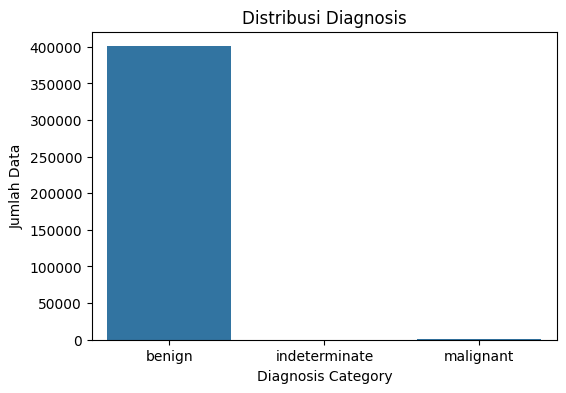


Contoh gambar kategori: benign


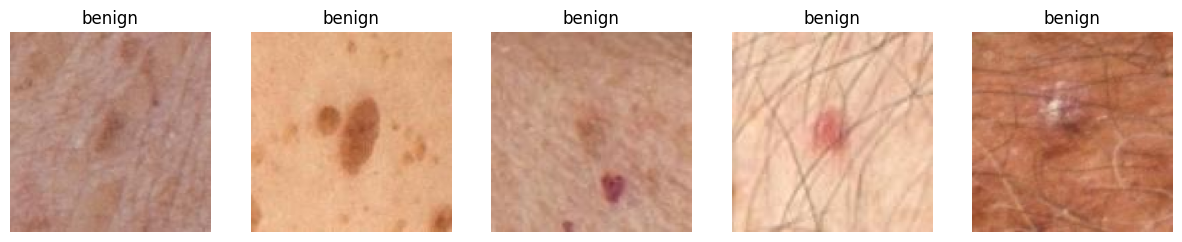


Contoh gambar kategori: indeterminate
Tidak ada data untuk kategori indeterminate

Contoh gambar kategori: malignant


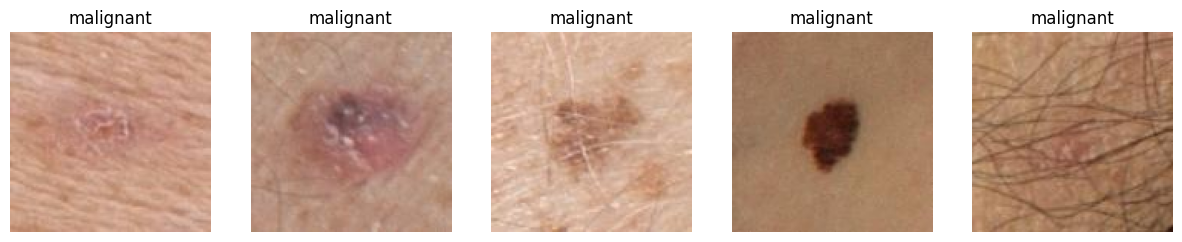

In [10]:
# === EDA Diagnosis dari iddx_1 ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import random

# Normalisasi kolom iddx_1 agar konsisten
train_df['iddx_1'] = train_df['iddx_1'].str.lower().str.strip()

# Filter hanya tiga kategori utama
valid_categories = ['malignant', 'ndeterminate', 'benign']
train_df = train_df[train_df['iddx_1'].isin(valid_categories)]

# Tampilkan distribusi kategori
print("Distribusi kategori (berdasarkan iddx_1):")
print(train_df['iddx_1'].value_counts())

# Visualisasi distribusi
plt.figure(figsize=(6,4))
sns.countplot(x='iddx_1', data=train_df, order=['benign', 'indeterminate', 'malignant'])
plt.title('Distribusi Diagnosis')
plt.xlabel('Diagnosis Category')
plt.ylabel('Jumlah Data')
plt.show()

# Tampilkan contoh gambar per kategori
def display_sample_images_by_category(df, category, num_samples=5):
    subset = df[df['iddx_1'] == category]
    if subset.empty:
        print(f"Tidak ada data untuk kategori {category}")
        return
    samples = subset.sample(min(num_samples, len(subset)))
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = row['filename']
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(category)
        else:
            axes[i].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
        axes[i].axis('off')
    plt.show()

# Contoh visualisasi gambar
for cat in ['benign', 'indeterminate', 'malignant']:
    print(f"\nContoh gambar kategori: {cat}")
    display_sample_images_by_category(train_df, cat)


# Data Preprocessing

In [ ]:
# =========================================================
# ✅ Data Preprocessing (ISIC 2024) - Train/Val Split 80/20 dari train-metadata.csv
# =========================================================
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, Image as HFImage, ClassLabel
from transformers import ViTImageProcessor
import torch
from torch.utils.data import DataLoader
from PIL import Image as PILImage
import numpy as np
from torchvision import transforms

# === 1️⃣ Load metadata ===
main_folder = r'D:\Rap_Gemastik2\isic-2024-challenge'
metadata_path = os.path.join(main_folder, 'train-metadata.csv')

train_df = pd.read_csv(metadata_path)

# Ambil kategori diagnosis dari kolom iddx_1 (sudah dibersihkan sebelumnya)
train_df['iddx_1'] = train_df['iddx_1'].str.lower().str.strip()
valid_classes = ['benign', 'intermediate', 'malignant']
train_df = train_df[train_df['iddx_1'].isin(valid_classes)]

# Tambahkan path penuh ke file gambar
train_df['filename'] = train_df['isic_id'].apply(
    lambda x: os.path.join(main_folder, 'train-image', 'image', f"{x}.jpg")
)

# === 2️⃣ Encode label ===
classes = sorted(valid_classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
train_df['label'] = train_df['iddx_1'].map(class_to_idx)
num_classes = len(classes)

# === 3️⃣ Split 80/20 untuk train dan validation ===
train_split, val_split = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'], random_state=42
)

# === 4️⃣ Create HuggingFace datasets ===
def create_hf_dataset(df, has_labels=True):
    data = {'image': [os.path.join(main_folder, f) for f in df['filename']]}
    if has_labels:
        data['label'] = df['label'].tolist()
    features = Features({'image': HFImage()})
    if has_labels:
        features['label'] = ClassLabel(names=classes)
    return Dataset.from_dict(data, features=features)

train_dataset = create_hf_dataset(train_split, True)
val_dataset = create_hf_dataset(val_split, True)
datasets = DatasetDict({'train': train_dataset, 'validation': val_dataset})

# === 5️⃣ Define processor & transforms ===
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

augment_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

augment_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === 6️⃣ MixUp augmentation ===
def mixup_data(x, y, alpha=0.4):
    """Apply mixup to a batch of tensors"""
    if alpha <= 0:
        return x, y, y, 1
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# === 7️⃣ Preprocess (apply transforms) ===
def preprocess(examples, is_train=True):
    imgs = examples["image"]
    if is_train:
        imgs = [augment_train(img.convert("RGB")) for img in imgs]
    else:
        imgs = [augment_val(img.convert("RGB")) for img in imgs]
    examples["pixel_values"] = torch.stack(imgs)
    return examples

datasets["train"] = datasets["train"].map(lambda x: preprocess(x, True), batched=True, batch_size=32)
datasets["validation"] = datasets["validation"].map(lambda x: preprocess(x, False), batched=True, batch_size=32)

datasets["train"].set_format(type="torch", columns=["pixel_values", "label"])
datasets["validation"].set_format(type="torch", columns=["pixel_values", "label"])

# === 8️⃣ Custom collate_fn (MixUp only for training) ===
def collate_fn(batch, mixup_alpha=0.4, is_train=True):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    if is_train:
        pixel_values, y_a, y_b, lam = mixup_data(pixel_values, labels, alpha=mixup_alpha)
        return {'pixel_values': pixel_values, 'labels_a': y_a, 'labels_b': y_b, 'lam': lam}
    else:
        return {'pixel_values': pixel_values, 'labels': labels}

train_loader = DataLoader(datasets["train"], batch_size=16, shuffle=True,
                          collate_fn=lambda b: collate_fn(b, mixup_alpha=0.1, is_train=True))
val_loader = DataLoader(datasets["validation"], batch_size=16, shuffle=False,
                        collate_fn=lambda b: collate_fn(b, mixup_alpha=0.1, is_train=False))

print("✅ Preprocessing selesai (80/20 split + augmentasi kuat + MixUp aktif)")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27172\954672337.py:19: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(metadata_path)


Map:   0%|          | 0/320756 [00:00<?, ? examples/s]

# Fine-Tuning

In [5]:
batch = next(iter(train_loader))
print(batch.keys())

dict_keys(['pixel_values', 'labels_a', 'labels_b', 'lam'])


In [6]:
# =========================================================
# ✅ Fine-Tuning ViT with Anti-Overfitting Strategies
# =========================================================
from transformers import ViTForImageClassification
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 🔹 Hyperparameters
learning_rate = 5e-5
num_epochs = 10
weight_decay = 0.1
patience = 3  # Early stopping patience
best_acc = 0
wait = 0

# =========================================================
# ✅ Model Setup (with dropout, regularization, and freeze)
# =========================================================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.4,              # lebih besar untuk regularisasi
    attention_probs_dropout_prob=0.4,
    layer_norm_eps=1e-5
).to(device)

# Freeze backbone temporarily (gradual unfreezing)
for name, param in model.vit.embeddings.named_parameters():
    param.requires_grad = False
for name, param in model.vit.encoder.layer[:6].named_parameters():
    param.requires_grad = False # hanya classifier yang aktif dulu

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2)

# =========================================================
# ✅ Loss Function with Label Smoothing
# =========================================================
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing=0.2):
        super().__init__()
        self.smoothing = smoothing
    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        nll = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth = -log_probs.mean(dim=-1)
        return ((1 - self.smoothing) * nll + self.smoothing * smooth).mean()

criterion = LabelSmoothingLoss(0.2)

# =========================================================
# ✅ Training & Validation Loops
# =========================================================
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        x = batch["pixel_values"].to(device)

        # MixUp data handling
        if "labels_a" in batch:
            y_a = batch["labels_a"].to(device)
            y_b = batch["labels_b"].to(device)
            lam = batch["lam"]
            if isinstance(lam, float):  # handle lam float
                lam = torch.tensor(lam, device=device)
        else:
            y_a = batch["labels"].to(device)
            y_b = None
            lam = None

        optimizer.zero_grad()
        outputs = model(pixel_values=x)
        if y_b is not None:
            loss = lam * criterion(outputs.logits, y_a) + (1 - lam) * criterion(outputs.logits, y_b)
        else:
            loss = criterion(outputs.logits, y_a)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    return total_loss / len(loader)


def eval_epoch(model, loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            x = batch["pixel_values"].to(device)
            y = batch["labels"].to(device)
            outputs = model(pixel_values=x)
            loss = criterion(outputs.logits, y)
            total_loss += loss.item()
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    acc = accuracy_score(labels, preds)
    return total_loss / len(loader), acc


# =========================================================
# ✅ Training Loop (with Early Stopping + History Tracking)
# =========================================================
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'fold': []
}

best_acc = 0
patience, patience_counter = 5, 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    # step scheduler once per epoch
    scheduler.step()

    # Simpan ke history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['fold'].append(1)  # kalau kamu cuma 1 training run

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping + model save
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Model improved and saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered.")
            break

    # Gradual unfreeze setelah epoch ke-3
    if epoch == 2:
        print("🔓 Gradually unfreezing ViT backbone layers...")
        for param in model.vit.encoder.layer[-4:].parameters():  # hanya 4 layer terakhir
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

print("🎯 Training complete with strong regularization.")


Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Validation: 100%|████████████████████| 13/13 [00:04<00:00,  3.07it/s]


Train Loss: 1.4493 | Val Loss: 1.4526 | Val Acc: 0.5450
✅ Model improved and saved.

Epoch 2/10


Validation: 100%|████████████████████| 13/13 [00:03<00:00,  3.31it/s]


Train Loss: 1.1412 | Val Loss: 1.3687 | Val Acc: 0.6750
✅ Model improved and saved.

Epoch 3/10


Validation: 100%|████████████████████| 13/13 [00:06<00:00,  2.08it/s]


Train Loss: 0.9243 | Val Loss: 1.0860 | Val Acc: 0.8700
✅ Model improved and saved.
🔓 Gradually unfreezing ViT backbone layers...

Epoch 4/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.35it/s]


Train Loss: 0.8044 | Val Loss: 0.9034 | Val Acc: 0.9150
✅ Model improved and saved.

Epoch 5/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.26it/s]


Train Loss: 0.7864 | Val Loss: 0.8319 | Val Acc: 0.9500
✅ Model improved and saved.

Epoch 6/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.25it/s]


Train Loss: 0.7742 | Val Loss: 0.8201 | Val Acc: 0.9650
✅ Model improved and saved.

Epoch 7/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.29it/s]


Train Loss: 0.7500 | Val Loss: 0.7972 | Val Acc: 0.9800
✅ Model improved and saved.

Epoch 8/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.23it/s]


Train Loss: 0.7837 | Val Loss: 0.7946 | Val Acc: 0.9800

Epoch 9/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.17it/s]


Train Loss: 0.7460 | Val Loss: 0.7946 | Val Acc: 0.9800

Epoch 10/10


Validation: 100%|████████████████████| 13/13 [00:05<00:00,  2.23it/s]

Train Loss: 0.7595 | Val Loss: 0.7923 | Val Acc: 0.9800
🎯 Training complete with strong regularization.


# Evaluation


📉 Loss History (Tabular Text):
+--------+---------+--------------+------------+
|   Fold |   Epoch |   Train Loss |   Val Loss |
+========+=========+==============+============+
|      1 |       1 |       1.4493 |     1.4526 |
+--------+---------+--------------+------------+
|      1 |       2 |       1.1412 |     1.3687 |
+--------+---------+--------------+------------+
|      1 |       3 |       0.9243 |     1.086  |
+--------+---------+--------------+------------+
|      1 |       4 |       0.8044 |     0.9034 |
+--------+---------+--------------+------------+
|      1 |       5 |       0.7864 |     0.8319 |
+--------+---------+--------------+------------+
|      1 |       6 |       0.7742 |     0.8201 |
+--------+---------+--------------+------------+
|      1 |       7 |       0.75   |     0.7972 |
+--------+---------+--------------+------------+
|      1 |       8 |       0.7837 |     0.7946 |
+--------+---------+--------------+------------+
|      1 |       9 |       0.746  |  

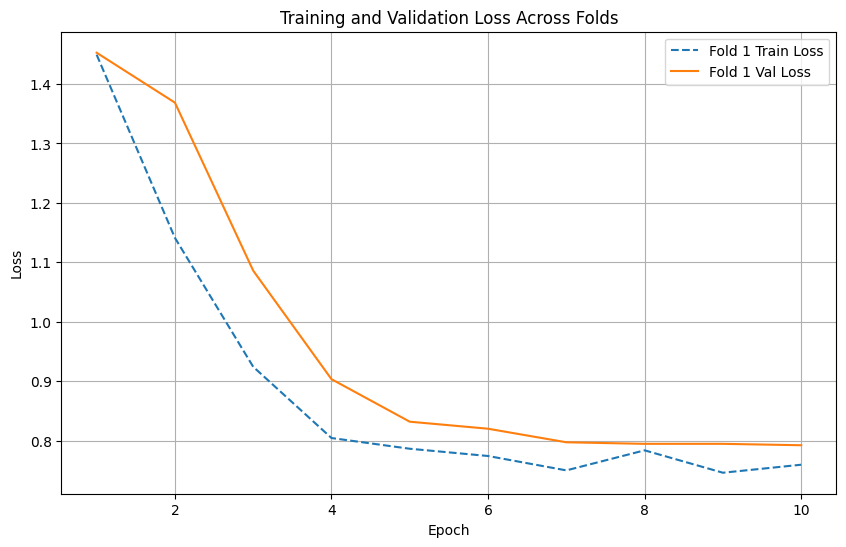


📊 Metrics History (Tabular Text):
+--------+---------+------------+
|   Fold |   Epoch |   Accuracy |
+========+=========+============+
|      1 |       1 |      0.545 |
+--------+---------+------------+
|      1 |       2 |      0.675 |
+--------+---------+------------+
|      1 |       3 |      0.87  |
+--------+---------+------------+
|      1 |       4 |      0.915 |
+--------+---------+------------+
|      1 |       5 |      0.95  |
+--------+---------+------------+
|      1 |       6 |      0.965 |
+--------+---------+------------+
|      1 |       7 |      0.98  |
+--------+---------+------------+
|      1 |       8 |      0.98  |
+--------+---------+------------+
|      1 |       9 |      0.98  |
+--------+---------+------------+
|      1 |      10 |      0.98  |
+--------+---------+------------+


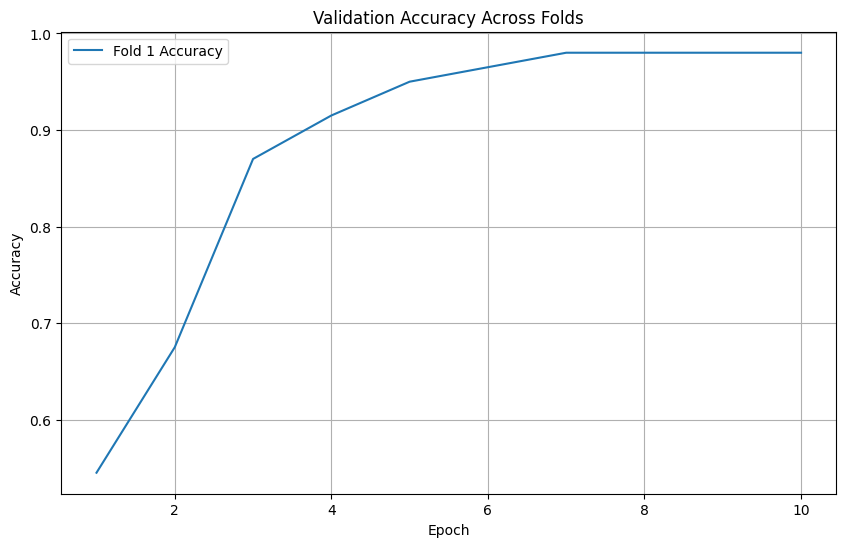


🧩 Test Set Classification Report:

Unique labels in test set: [-1]
Number of unique labels: 1

⚠️ Tidak ada label valid ditemukan setelah filtering. Pastikan test_df memiliki label yang sesuai.


In [7]:
# =========================================================
# ✅ EVALUATION BLOCK (FINAL + FIXED)
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# =========================================================
# 1️⃣ LOSS HISTORY (TABULAR)
# =========================================================
print("\n📉 Loss History (Tabular Text):")
loss_table = []
for i in range(len(history['fold'])):
    loss_table.append([
        history['fold'][i],
        history['epoch'][i],
        f"{history['train_loss'][i]:.4f}",
        f"{history['val_loss'][i]:.4f}"
    ])
print(tabulate(loss_table, headers=["Fold", "Epoch", "Train Loss", "Val Loss"], tablefmt="grid"))

# =========================================================
# 2️⃣ LOSS GRAPH
# =========================================================
k_folds = len(set(history['fold']))
plt.figure(figsize=(10, 6))
for fold in range(1, k_folds + 1):
    fold_mask = [i for i, f in enumerate(history['fold']) if f == fold]
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['train_loss'][i] for i in fold_mask],
             label=f'Fold {fold} Train Loss', linestyle='--')
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['val_loss'][i] for i in fold_mask],
             label=f'Fold {fold} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 3️⃣ ACCURACY HISTORY
# =========================================================
print("\n📊 Metrics History (Tabular Text):")
metrics_table = []
for i in range(len(history['fold'])):
    metrics_table.append([
        history['fold'][i],
        history['epoch'][i],
        f"{history['val_accuracy'][i]:.4f}"
    ])
print(tabulate(metrics_table, headers=["Fold", "Epoch", "Accuracy"], tablefmt="grid"))

plt.figure(figsize=(10, 6))
for fold in range(1, k_folds + 1):
    fold_mask = [i for i, f in enumerate(history['fold']) if f == fold]
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['val_accuracy'][i] for i in fold_mask],
             label=f'Fold {fold} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 4️⃣ CLASSIFICATION REPORT (FULL TEST SET)
# =========================================================
print("\n🧩 Test Set Classification Report:")
all_test_preds = []
all_test_labels = []

test_df_with_labels = test_df.merge(train_df[['filename', 'label']], on='filename', how='left')
test_labels = test_df_with_labels['label'].fillna(-1).astype(int).tolist()

model.eval()
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(test_labels[:len(preds)])

# --- CEK LABEL VALID ---
unique_labels = np.unique(all_test_labels)
print(f"\nUnique labels in test set: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

valid_mask = np.array(all_test_labels) >= 0
filtered_labels = np.array(all_test_labels)[valid_mask]
filtered_preds = np.array(all_test_preds)[valid_mask]

unique_label_ids = sorted(np.unique(filtered_labels))
if len(unique_label_ids) == 0:
    print("\n⚠️ Tidak ada label valid ditemukan setelah filtering. Pastikan test_df memiliki label yang sesuai.")
else:
    used_classes = [classes[i] for i in unique_label_ids if i < len(classes)]

    print("\n📋 Final Classification Report:")
    print(classification_report(
        filtered_labels,
        filtered_preds,
        labels=unique_label_ids,
        target_names=used_classes,
        zero_division=0
    ))

    # --- Confusion Matrix (Full Test) ---
    test_cm = confusion_matrix(filtered_labels, filtered_preds, labels=unique_label_ids)
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=used_classes, yticklabels=used_classes)
    plt.title('Confusion Matrix - Full Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # =========================================================
    # 5️⃣ SIMULASI LEADERBOARD (60% PUBLIC / 40% PRIVATE SPLIT)
    # =========================================================
    print("\n🏆 Leaderboard Simulation (Public vs Private 60:40)")

    X_60, X_40, y_60, y_40 = train_test_split(
        filtered_preds, filtered_labels, test_size=0.4, random_state=42, stratify=filtered_labels
    )

    acc_60 = accuracy_score(y_60, X_60)
    f1_60 = f1_score(y_60, X_60, average='weighted')

    acc_40 = accuracy_score(y_40, X_40)
    f1_40 = f1_score(y_40, X_40, average='weighted')

    print("\n==================== 🏅 LEADERBOARD SIMULATION ====================")
    print(f"Simulated Public Leaderboard (60% Test):")
    print(f"  Accuracy : {acc_60:.4f}")
    print(f"  F1-score : {f1_60:.4f}")

    print(f"\nSimulated Private Leaderboard (40% Remaining Test):")
    print(f"  Accuracy : {acc_40:.4f}")
    print(f"  F1-score : {f1_40:.4f}")
    print("================================================================")

    # Confusion Matrix 60%
    cm_60 = confusion_matrix(y_60, X_60)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_60, annot=True, fmt='d', cmap='Greens',
                xticklabels=used_classes, yticklabels=used_classes)
    plt.title('Confusion Matrix - Simulated Public Leaderboard (60%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Confusion Matrix 40%
    cm_40 = confusion_matrix(y_40, X_40)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_40, annot=True, fmt='d', cmap='Oranges',
                xticklabels=used_classes, yticklabels=used_classes)
    plt.title('Confusion Matrix - Simulated Private Leaderboard (40%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\n✅ Evaluation completed successfully.")


# Submission

In [8]:
# =========================================================
# ✅ FINAL INFERENCE & SUBMISSION GENERATION (SAFE VERSION)
# =========================================================
import pandas as pd
import os
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

# --- Generate predictions on test set ---
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting Test Set"):
        pixel_values = batch["pixel_values"].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())

# --- Safety Checks for Classes ---
if 'classes' not in locals():
    raise ValueError("❌ 'classes' variable is missing. Please define your class names list.")

# --- Clip prediction indices if needed ---
test_preds = np.array(test_preds, dtype=int)
test_preds = np.clip(test_preds, 0, len(classes) - 1)

# --- Map predictions to class labels ---
predicted_classes = [classes[i] for i in test_preds]

# --- Create submission DataFrame ---
if 'test_df' not in locals():
    raise ValueError("❌ 'test_df' variable not found. It should contain test data with an 'id' column.")

submission_df = pd.DataFrame({
    'id': test_df['id'].values[:len(predicted_classes)],  # safety for unequal lengths
    'class': predicted_classes
})

# --- Save submission file ---
main_folder = os.getcwd()
save_path = os.path.join(main_folder, 'submission.csv')
submission_df.to_csv(save_path, index=False)

print(f"\n✅ Submission file successfully created: {save_path}")
print("📋 Preview:")
print(submission_df.head())


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_692\4166838333.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locati


✅ Submission file successfully created: D:\Rap_Gemastik2\submission.csv
📋 Preview:
     id       class
0  1001      Tennis
1  1002      Soccer
2  1003      Tennis
3  1004  Volleyball
4  1005  Volleyball
